# Regression Exploration exercises

In [126]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import wrangle
from explore import plot_categorical_and_continuous_vars
from env import get_db_url
import os

from sklearn.model_selection import train_test_split
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Exercises I - Required

Our Telco scenario continues:

As a customer analyst for Telco, you want to know who has spent the most money with the company over their lifetime. You have monthly charges and tenure, so you think you will be able to use those two attributes as features to estimate total charges. You need to do this within an average of $5.00 per customer.

In [127]:
## Functions pulled from previous project
def get_telco_data(use_cache=True):
    '''
    This function uses the create_url() funciton to retrieve the requested data and 
    returns a dataframe.
    '''
    filename = 'telco.csv'
    if os.path.exists(filename) and use_cache:
        print('Using cached csv file...')
        return pd.read_csv(filename)
    
    print('Getting a fresh copy from the database...')
    url = get_db_url('telco_churn')
    telco_data = pd.read_sql('''
    SELECT *
    FROM customers
    JOIN contract_types
    USING(contract_type_id)
    JOIN payment_types
    USING(payment_type_id)
    JOIN internet_service_types
    USING(internet_service_type_id)
    ''', url)
    
    print('Saving to csv...')
    telco_data.to_csv(filename, index=False)
    return telco_data

def prep_telco(df):
    
    #This function prepares the data for exploration.
    
    # Drop duplicate columns
    
    drop_columns = ['internet_service_type_id',
                    'payment_type_id',
                    'contract_type_id']    
    
    df = df.drop(columns=drop_columns)
    
    # Drop whitespace values in total_charges
    
    df['total_charges'] = df['total_charges'].str.strip()
    
    df = df[df.total_charges != '']
    
    # Convert total_charges to the correct data type
    
    df['total_charges'] = df['total_charges'].astype(float)
    
    # convert categorical data that is binary in nature to numeric binary characters
    
    df['gender'] = df.gender.str.replace('Male', '1').str.replace('Female', '0')
    df['partner'] = df.partner.str.replace('Yes', '1').str.replace('No', '0')
    df['dependents'] = df.dependents.str.replace('Yes', '1').str.replace('No', '0')
    df['phone_service'] = df.phone_service.str.replace('Yes', '1').str.replace('No', '0')    
    df['paperless_billing'] = df.paperless_billing.str.replace('Yes','1')\
                                                 .str.replace('No', '0')
    df['churn'] = df.churn.str.replace('Yes', '1')\
                          .str.replace('No', '0')
    
    df[['gender','partner','dependents',\
        'phone_service','paperless_billing','churn']]\
                             = df[['gender','partner','dependents',
                                   'phone_service','paperless_billing',
                                   'churn']].astype(int)
    
    # Create dummy variables for categorical variables
    
    dummy_name = pd.get_dummies(df[['multiple_lines',
                                    'online_security', 
                                    'online_backup',
                                    'device_protection',
                                    'tech_support',
                                    'streaming_tv',
                                    'streaming_movies',
                                    'contract_type',
                                    'payment_type',
                                    'internet_service_type']],
                                    dummy_na=False)
    
    # Combine dataframes to include all variables
    
    df = pd.concat([df,dummy_name],axis=1)
    
    # Rename columns to remove spaces
    
    df = df.rename(columns = {'contract_type_One year' : 'contract_type_One_year', 
                     'contract_type_Two year' : 'contract_type_Two_year', 
                     'payment_type_Bank transfer (automatic)' : 'payment_type_Bank_transfer_(automatic)', 
                     'payment_type_Credit card (automatic)' : 'payment_type_Credit_card_(automatic)', 
                     'payment_type_Electronic check' : 'payment_type_Electronic_check', 
                     'payment_type_Mailed check' : 'payment_type_Mailed_check', 
                     'multiple_lines_No phone service' : 'multiple_lines_No_phone_service', 
                     'online_security_No internet service' : 'online_security_No_internet_service', 
                     'online_backup_No internet service' : 'online_backup_No_internet_service', 
                     'device_protection_No internet service' : 'device_protection_No_internet_service', 
                     'tech_support_No internet service' : 'tech_support_No_internet_service', 
                     'streaming_tv_No internet service' : 'streaming_tv_No_internet_service', 
                     'streaming_movies_No internet service' : 'streaming_movies_No_internet_service', 
                     'internet_service_type_Fiber optic': 'internet_service_type_Fiber_optic'})
    
    # Create a column that gives a count of additional services for each customer
    
    df['service_count'] = (df[['online_security_Yes', 'online_backup_Yes','device_protection_Yes', 
                               'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes']] == 1).sum(axis=1)
    
    # Output cleaned DataFrame
    
    return df

def train_validate_test_split(df, target):
    
    # Splits data into train, validate and tests sets for further processesing. Use target variable to stratify data to ensure class frequencies. 
    
    train_validate, test = train_test_split(df, test_size=0.2, random_state=123, stratify=df[target])
    
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=123, stratify=train_validate[target])
    
    # Returns the split data with train making up 56% of the data, validate making up 24% of the data and test representing the remaining 20%
    
    return train, validate, test

def clean_split_telco(df, target):
    
    # Uses both prep and split functions to fully prepare data
    
    cleaned_df = prep_telco(df)
    
    train, validate, test = train_validate_test_split(cleaned_df, target)
    
    # Returns the fully preped data for further analysis
    
    return train, validate, test

In [128]:
telco = get_telco_data()

Using cached csv file...


1) Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [129]:
train, validate, test = clean_split_telco(telco, 'churn')

2) Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

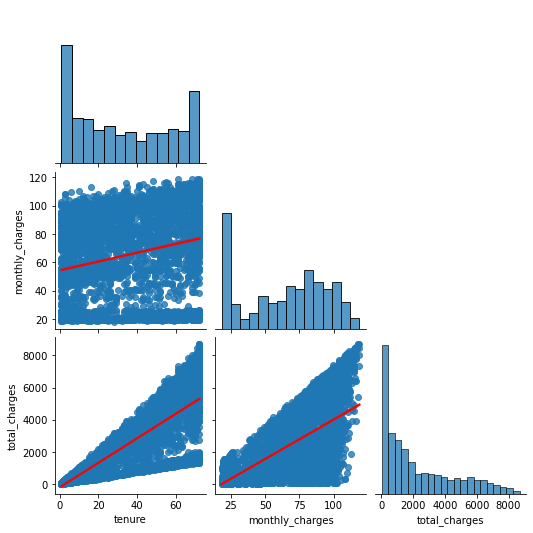

In [130]:
def plot_variable_pairs(df):
    sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}},corner=True)
    
plot_variable_pairs(train[['tenure','monthly_charges','total_charges']])

3. Write a function named months_to_years that accepts your telco churn dataframe and returns a dataframe with a new feature tenure_years, in complete years as a customer.

In [131]:
def months_to_years(df):
    df['tenure_years'] = (df.tenure / 12).astype('int') 
    
months_to_years(train)
train.tenure_years.head()

6135    6
2034    2
5390    3
2574    0
6418    4
Name: tenure_years, dtype: int64

4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [1]:
continuous_var = ['monthly_charges','total_charges']
categorical_var = ['gender','senior_citizen','partner','dependents',\
             'phone_service','multiple_lines', 'online_security',\
             'online_backup','device_protection', 'tech_support',\
             'streaming_tv', 'streaming_movies','contract_type',\
             'payment_type', 'internet_service_type','churn']
discrete_var = ['tenure','service_count']

def plot_categorical_and_continuous_vars(df, continuous_features, categorical_features):
    for cat in categorical_var:
        for con in continuous_var:
            fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(14,8))
            sns.boxplot(x=cat, y= con, data=train, ax=ax[0])
            sns.swarmplot(x=cat, y= con, data=train, ax=ax[0], zorder=0)
            sns.stripplot(x=cat, y= con, data=train, ax=ax[1])
            sns.barplot(x=cat, y=con, data=train, ax=ax[2])
            plt.show()
            
#print(plot_categorical_and_continuous_vars(train, continuous_var, categorical_var))

In [2]:
# for cat in categorical_var:
#         for con in continuous_var:
#             fig, ax = plt.subplots(ncols=3, figsize=(14,8))
#             sns.boxplot(x=cat, y= con, data=train, ax=ax[0])
#             sns.swarmplot(x=cat, y= con, data=train, ax=ax[0], zorder=0)
#             sns.stripplot(x=cat, y= con, data=train, ax=ax[1])
#             sns.barplot(x=cat, y=con, data=train, ax=ax[2])
#             plt.show()

5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

In [3]:
# plot_categorical_and_continuous_vars(train, continuous_var, categorical_var)

6. Explore your dataset with any other visualizations you think will be helpful.

In [ ]:
for cat in categorical_var:
    for con in continuous_var:        
        fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(14,8))
        sns.boxplot(x=cat, y= con, data=train, hue = 'churn', ax=ax[0])
        sns.barplot(x=cat, y= con, data=train, hue = 'churn', ax=ax[1])
        sns.swarmplot(x=cat, y= con, data=train, hue = 'churn', ax=ax[2])

In [ ]:
for cat in categorical_var:
    for dis in discrete_var:
        fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(14,8))
        sns.boxplot(x=dis, y= cat, data=train, hue = 'churn', ax=ax[0])
        sns.barplot(x=dis, y= cat, data=train, hue = 'churn', ax=ax[1])
        sns.swarmplot(x=dis, y= cat, data=train, hue = 'churn', ax=ax[2])

In [ ]:
for cat in categorical_var:
        for con in continuous_var:
            fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(14,8))
            sns.swarmplot(x='service_count', y= con, data=train, hue = cat, ax=ax[0])
            sns.boxplot(x='service_count', y= con, data=train, hue = cat, ax=ax[1])
            sns.stripplot(x='service_count', y= con, data=train, hue = cat, ax=ax[2])

In [ ]:
for cat in categorical_var:
        for con in continuous_var:
            fig, ax = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(14,8))
            sns.swarmplot(x='service_count', y= con, data=train, hue = cat, ax=ax[0])
            sns.boxplot(x='service_count', y= con, data=train, hue = cat, ax=ax[0])
            sns.stripplot(x='service_count', y= con, data=train, hue = cat, ax=ax[1])

In [ ]:
for cat in categorical_var:
        for con in continuous_var:
            fig, ax = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(14,8))
            sns.swarmplot(x=con, y= cat, data=train, ax=ax[0])
            sns.boxplot(x=con, y= cat, data=train, ax=ax[0])
            sns.stripplot(x=con, y= cat, data=train, ax=ax[1])

7. In a seperate notebook, use the functions you have developed in this exercise with the mall_customers dataset in the Codeup database server. You will need to write a sql query to acquire your data. Make spending_score your target variable.

- See mall_customers.ipynb

## Exercises II - Challenge
Our Zillow scenario continues:

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.Exercises II - Challenge
Our Zillow scenario continues:

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

1. Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

2. Come up with some initial hypotheses based on your goal of predicting property value.

3. Visualize all combinations of variables in some way.

4. Run the appropriate statistical tests where needed.

5. What independent variables are correlated with the dependent variable, home value?

6. Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

7. Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.